# HackGT AI Workshop

This is a Colaboratory notebook. Notebooks like this are often used in data science and machine learning because they provide a unified environment for code, text, and charts.


**If you want to edit or interact with this notebook, use the `playground` button!**


---

# Topics

- Basic Data Manipulation with Pandas
- Turning words into vectors
- Semantic Search Engines!


## Setup

Cells can contain code or text. You can run a code by clicking the run button to the left or by pressing shift-enter.

Try running the cell below to make sure everything is working (make sure you've entered playground mode)

In [ ]:
print("Hello talk!!")

Hello talk!!


Colaboratory has a lot of useful libraries installed automatically. Below are some standard imports that you'll see in nearly every single ML project.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1.0: Pandas!
![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/Grosser_Panda.JPG/218px-Grosser_Panda.JPG)
  

---




- `pandas` is a staple library for machine learning and data science
- Think of it as a **very** fast csv wrapper
  - sql style operations
  - charts
  - makes life easier by replacing lots of for loops


The main abstraction is a `DataFrame`, often as a variable called `df`.  
  
  When I say dataframe, think table.
  
  Most of the operations are pretty self explanatory.
  
  Below, we'll read a CSV file that I've prepared containing submissions from HackGT last year.
  

In [ ]:
# this can also be a local (to the cloud instance) file!
location = 'https://gist.githubusercontent.com/ruyimarone/04d356038138f12df205da9934e797f1/raw/e3bb9212eae46e10f85b765f5a3ab95e0428c3ee/data.csv'
df = pd.read_csv(location)
# this drops any rows that have NaN values or other missing entries - we won't worry about them
df = df.dropna()
#this drops anything that is too short
df = df[df.description.str.len() > 100]

We can check the contents of a `DataFrame` by inspecting the first few rows:

In [ ]:
df.head()

,submission,description,tags
0,Cinema4All,Inspiration\n\nWhen exploring different proble...,"azure, react, heroku, css, javascript"
1,helpr,Inspiration\n\nWhen considering the types of u...,"love, caffeine, android-studio, arduino, iot, ..."
2,Book Match: Vocabing,Inspiration\n\nGRE Test Prep\n\nWhat it does\n...,"python, mysql, azure, nltk, natural-language-p..."
3,Parking sensor,"Inspiration\n\nOne day, while driving, Sarah b...","arduino, pwm"
4,HackGTOne,Inspiration\n\nWe wanted to improve the custom...,"java, android"


We can also do advanced selections. For example, if we wanted every project that was tagged on devpost with python:

In [ ]:
df[df.tags.str.contains('python') & df.tags.str.contains('pandas')].head()

,submission,description,tags
7,Airline Delays Visualization,Inspiration\n\nI love airplanes and big data i...,"pandas, numpy, python, jupyter-notebook"
92,Huber,Huber\n\nHuber is new. It's different. All you...,"typescript, jupyter-notebook, python, javascri..."
135,InvestFolio,Inspiration\n\nEasy to use. Free. \n\nWhat it ...,"php, google-cloud, scikit-learn, python, mysql..."


Let's compare some libraries and languages:

In [ ]:
df[df['tags'].str.contains('python')].tags.count()

66

In [ ]:
df[df['tags'].str.contains('node.js')].tags.count()

30

## 2.0 NLP: Words as Vectors


---

Back to the slides!





### 2.1 Getting Terms and Documents

Imports and boilerplate...

In [ ]:
#also super common
import nltk #natural language toolkit
import sklearn #python library for classical machine learning

`CountVectorizer` : generates bag of word vectors

In [ ]:
cv = sklearn.feature_extraction.text.CountVectorizer()
m = cv.fit_transform(['this is a document', 'this is a second document', 'third document document document']).todense()
print(cv.vocabulary_)
print(m)

{'this': 4, 'is': 1, 'document': 0, 'second': 2, 'third': 3}
[[1 1 0 0 1]
 [1 1 1 0 1]
 [3 0 0 1 0]]


Now we can get a term document matrix from the submissions dataframe.


In [ ]:
count_vectorizer = sklearn.feature_extraction.text.CountVectorizer()
td_count_matrix = count_vectorizer.fit_transform(df['tags'])

Note that the count vectorizer handles tokenization for us. Tokenization broadly means turning a sentence into word or word like chunks. Easiest way - `sentence.split()`

Let's see what the matrix looks like:

In [ ]:
td_count_matrix.shape

(175, 305)

So we have 177 documents and 305 unique terms.

Here's a snippet of the vocab, to convince you that the tokenization worked:

In [ ]:
list(count_vectorizer.vocabulary_.items())[:10]

[('azure', 32),
 ('react', 234),
 ('heroku', 130),
 ('css', 69),
 ('javascript', 147),
 ('love', 168),
 ('caffeine', 48),
 ('android', 14),
 ('studio', 269),
 ('arduino', 23)]

### 2.2 Clustering Tags

In [ ]:
from sklearn.decomposition import TruncatedSVD as SVD
svd = SVD(10)
svd.fit(td_count_matrix)

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=5,
       random_state=None, tol=0.0)

`sklearn` provides us with very nice abstractions, calculating this complicated matrix decomposition is that simple.

There are lots of things we can do with this matrix (like search), but for now let's examine the similar words:

In [ ]:
from IPython.core.display import display, HTML
def tabulate(data, header=True):
    display_df = pd.DataFrame(data)
    display(HTML(display_df.to_html(index=False, header=header)))

In [ ]:
data = []
for i in range(len(svd.components_)):
    scores = []
    words = []
    topk = sorted(zip(svd.components_[i], count_vectorizer.get_feature_names()), reverse=True)[:10]
    scores, words = zip(*topk)
    data.append(scores)
    data.append(words)
tabulate(data)

0,1,2,3,4,5,6,7,8,9
0.42948,0.405186,0.292172,0.239077,0.233803,0.210985,0.202825,0.194406,0.187247,0.171321
js,javascript,python,api,node,html,css,android,azure,html5
0.569338,0.305759,0.28634,0.212995,0.205829,0.195477,0.156634,0.104973,0.10156,0.0918916
android,java,studio,google,api,firebase,maps,aws,microsoft,xml
0.531912,0.330388,0.27287,0.227206,0.14458,0.128784,0.106199,0.106149,0.0989379,0.0886033
api,bing,microsoft,azure,cognitive,search,ncr,maps,html5,css3
0.505676,0.303183,0.113081,0.106586,0.102587,0.102334,0.0768855,0.0764952,0.0702189,0.0597339
js,node,amazon,express,bing,services,alexa,maps,api,mongodb
0.524578,0.255791,0.244996,0.188578,0.108815,0.105405,0.0947743,0.0928982,0.064114,0.0637233
python,flask,js,amazon,d3,ncr,unity,web,azure,machine


- These reduced features are linear combinations of the old ones
  - we could call the first one a webdev-ish dimension
  - there's also an ML/NLP dimension <3
- Not always interpretable
- SVD doesn't care about broader language - it only cares about co occurrences

Let's look at the actual matrix and see if it tells us anything useful:


In [ ]:
#get the 50 most common tags
from collections import Counter
tag_counts = Counter()
for tags in df.tags.values:
    tag_counts.update((t for t in tags.split(', ') if t in count_vectorizer.vocabulary_))

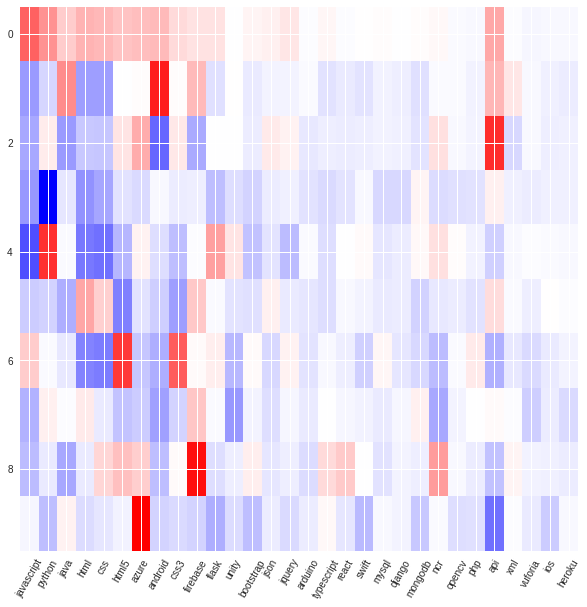

In [ ]:
N = 30
ixs_of_interest = []
for tag, _ in tag_counts.most_common(N):
    ixs_of_interest.append(count_vectorizer.vocabulary_[tag])
mat = svd.components_[:, ixs_of_interest]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mat, aspect='auto', cmap='bwr')
ax.set_xticks(range(N))
ax.set_xticklabels([t for t, _ in tag_counts.most_common(N)], rotation=60)
ax.xaxis.set_ticks_position('none')

This gives us an idea of the actual topic structures

### 2.3 Clustering Documents

I'll repeat the experiment, using the full `descriptions` instead of just the `tags` columns.

In [ ]:
# vectorize the documents
count_vectorizer = sklearn.feature_extraction.text.CountVectorizer()
td_count_matrix = count_vectorizer.fit_transform(df['description'])
svd = SVD(10)
svd.fit(td_count_matrix)

data = []
for i in range(len(svd.components_)):
    scores = []
    words = []
    topk = sorted(zip(svd.components_[i], count_vectorizer.get_feature_names()), reverse=True)[:10]
    scores, words = zip(*topk)
#     data.append(scores)
    data.append(words)

tabulate(data)

0,1,2,3,4,5,6,7,8,9
the,to,and,we,of,in,that,for,it,with
we,to,and,our,it,what,how,as,learned,that
and,to,is,you,my,it,app,this,or,what
to,ingredients,app,that,user,recipes,as,model,recipe,users
of,our,and,model,app,in,recipes,recipe,data,database
our,is,keyboard,that,be,would,could,one,have,keyboards
you,data,that,is,your,model,recipes,keyboard,then,recipe
and,the,you,we,api,will,app,your,microsoft,vision
data,for,app,predict_,if,is,price,our,amount,it
in,as,are,with,if,people,predict_,price,you,by


- Those are boring
- Why?
  - Lots of confounding words!
  - Lots of useless co-occurrence data
    - it doesn't help me to know that *the* appears often with *application*

---

    
We can solve this!

Replace our bag of words with a bag of tricks:
- use **tf-idf** instead of basic word counts
- remove useless **stop words**

In [ ]:
#I manually created this list so it would be easy to add your own as you experiment
#In reality you could do something like filter the top N most frequent words (similar to IDF)
stop_words = ['the', 'to', 'we', 'and', 'of', 'it', 'in', 'for', 'with', 'is', 'this', 'my', \
              'that', 'our', 'what', 'on', 'as', 'you', 'was']
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stop_words) # this has lots of parameters - experiment!
# sklearn.feature_extraction.text.TfidfVectorizer?

In [ ]:
# vectorize the documents
tfidf_matrix = tfidf_vectorizer.fit_transform(df['description'])
svd = SVD(10)
svd.fit(tfidf_matrix)
data = []
for i in range(len(svd.components_)):
    scores = []
    words = []
    topk = sorted(zip(svd.components_[i], tfidf_vectorizer.get_feature_names()), reverse=True)[:10]
    _, words = zip(*topk)
    data.append(words)
tabulate(data)

0,1,2,3,4,5,6,7,8,9
data,app,application,can,how,an,user,are,be,into
data,stock,analysis,fraud,risk,sentiment,finra,api,python,model
alexa,game,unity,motion,skill,lambda,how,aws,virtual,reality
alexa,skill,lambda,aws,node,js,jira,learnt,voice,amazon
ingredients,recipe,recipes,ncr,model,food,end,speech,items,ingredient
alexa,myo,android,unity,ingredients,vr,armband,lambda,skill,drone
application,notes,students,will,text,microsoft,vision,image,api,speech
chatbot,bot,recipe,ingredients,recipes,unity,flight,their,questions,ncr
parking,park,car,parkme,spots,very,end,us,general,unity
python,stock,motion,api,google,music,food,notes,leap,location


## 3.0: Search

---



- We've shown how to vectorize documents
- We've shown that some of these vectors have semantic properties

Now, we can try to create a search engine using these vectors!




### 3.1 Information Retreival

See slides


---





### 3.2 Classical Methods

We can use either **count vectors (tfidf)** or **lsa vectors** in our search engine.


First, some set up:

In [ ]:
#fetch a dataset...
nltk.download('punkt')


hack_documents = [
    "Use machine learning on text messages to predict when you are hungry.",
    "Tour college campuses using an oculus rift.",
    "Use blockchain to keep track of which roommate needs to take out the trash."
]

def tokenize(raw_text, vocab = None):
    tokens = []
    for sentence in nltk.sent_tokenize(raw_text):
        tokens += nltk.word_tokenize(sentence)
    tokens = [t.lower() for t in tokens if not vocab or t.lower() in vocab]
    return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The rest of this is some dense boilerplate. Important parts:

- `tfidf_model` and `lsa_model` are functions that take a `query` and `document` and return a score (higher is better)
- `search` takes a model, documents, and a query and returns the document with the highest score.

There are much better ways to implement this, but this works and is simple. Really,  you should precompute and store all the document vectors in a single matrix, and then do a matrix vector product to calculate all the scores at once.

In [ ]:
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stop_words)
tfidf_matrix = tfidf_vectorizer.fit_transform([' '.join(tokenize(d)) for d in df['description']])
svd = SVD(10)
svd.fit(tfidf_matrix)

def cosine(a, b):
    eps = 1e-8
    if type(a) is np.ndarray:
        return a.dot(b) / ((np.linalg.norm(a) * np.linalg.norm(b)) + eps)
    else:
        return a.dot(b) / ((a.norm() * b.norm()) + eps)

def tfidf_model(query, document):
    query_vector = tfidf_vectorizer.transform([' '.join(tokenize(query, tfidf_vectorizer.get_feature_names()))]).todense()
    doc_vector = tfidf_vectorizer.transform([' '.join(tokenize(document, tfidf_vectorizer.get_feature_names()))]).todense()
    doc_vector = np.squeeze(np.asarray(doc_vector))
    query_vector = np.squeeze(np.asarray(query_vector))
    return cosine(query_vector, doc_vector)

def lsa_model(query, document):
    query = ' '.join(tokenize(query, tfidf_vectorizer.get_feature_names()))
    document = ' '.join(tokenize(document, tfidf_vectorizer.get_feature_names()))
    query_vector = tfidf_vectorizer.transform([query]).todense()
    doc_vector = tfidf_vectorizer.transform([document]).todense()
    query_vector = svd.transform(query_vector)
    doc_vector = svd.transform(doc_vector)
    return cosine(np.squeeze(np.asarray(doc_vector)), np.squeeze(np.asarray(query_vector)))

def search(model, query, documents, names = None):
    scores = [model(query, document) for document in documents]
    ixs = list(reversed(np.argsort(scores)[-10:]))

    data = [[scores[i] for i in ixs], [documents[i][:150] for i in ixs]]
    if names is not None:
        data.append([names[i] for i in ixs])
    tabulate(data, header=False)

In [ ]:
#search for a known keyword, using just keyword matches
search(tfidf_model, "trash", hack_documents)

0.517868,0,0
Use blockchain to keep track of which roommate...,Tour college campuses using an oculus rift.,Use machine learning on text messages to predi...


In [ ]:
#search for keywords that don't exist in the corpus
search(lsa_model, "virtual reality", hack_documents)


0.774182,0.135699,0.107
Tour college campuses using an oculus rift.,Use blockchain to keep track of which roommate...,Use machine learning on text messages to predi...


In [ ]:
#let's experiment here
search(lsa_model, "unity", hack_documents)

0.715943,0.172734,0.0117467
Tour college campuses using an oculus rift.,Use blockchain to keep track of which roommate...,Use machine learning on text messages to predi...


Here is a failure case

In [ ]:
search(tfidf_model, "university visits", hack_documents)
search(lsa_model, "university visits", hack_documents)

0,0,0
Use blockchain to keep track of which roommate...,Tour college campuses using an oculus rift.,Use machine learning on text messages to predi...


0.129671,-0.0386039,-0.161388
Use machine learning on text messages to predi...,Tour college campuses using an oculus rift.,Use blockchain to keep track of which roommate...


## 4.0 Deep Learning

In [ ]:
#install some libs
!pip install torch torchtext

### 4.1 Word Embeddings

Run the cell above, and while it's installing follow along in the slides.

In [ ]:
import torch, torchtext
word2vecin = torchtext.vocab.Vectors('in_pruned_lite.txt', url='http://github.com/ruyimarone/SemanticSearch/raw/master/in.zip', cache = '.')
word2vecout = torchtext.vocab.Vectors('out_pruned_lite.txt', url='https://github.com/ruyimarone/SemanticSearch/raw/master/out.zip', cache = '.')

In [ ]:
def get_doc_vector(tokens, embedding = word2vecout):
    q = sum(embedding[t] / embedding[t].norm() for t in tokens) / len(tokens)
    return q

def desm_model(query, document, embedding = word2vecin):
    query_tokens = tokenize(query, vocab=word2vecin.stoi)
    doc_tokens = tokenize(document, vocab=word2vecin.stoi)
    if len(doc_tokens) == 0:
        return -np.inf
    doc_vector = get_doc_vector(doc_tokens)
    return (sum(cosine(word2vecin[t], doc_vector) for t in query_tokens) / len(query_tokens)).item()

In [ ]:
search(desm_model, "virtual reality", hack_documents)

-0.0316041,-0.0772206,-0.0832169
Tour college campuses using an oculus rift.,Use machine learning on text messages to predi...,Use blockchain to keep track of which roommate...


In [ ]:
search(desm_model, "natural language processing", hack_documents)

-0.0463596,-0.0649365,-0.0666111
Use machine learning on text messages to predi...,Tour college campuses using an oculus rift.,Use blockchain to keep track of which roommate...


In [ ]:
search(desm_model, "university visits", hack_documents)

-0.0693108,-0.0698456,-0.0840284
Tour college campuses using an oculus rift.,Use blockchain to keep track of which roommate...,Use machine learning on text messages to predi...


Some more examples, with a new dataset. These documents don't have any overlap with the words in the original hackgt 4 devpost dataset, so the tfidf and lsa models won't work.

In [ ]:
food_documents = [
    "A fruit stand selling fresh produce from local farms.",
    "Sushi prepared by master chefs with fresh caught local fish.",
    "Burgers and smoked meat, served with fries and your choice of sauces."
]

search(desm_model, "tuna", food_documents)

-0.00265415,-0.00828872,-0.066288
Sushi prepared by master chefs with fresh caug...,"Burgers and smoked meat, served with fries and...",A fruit stand selling fresh produce from local...


In [ ]:
search(desm_model, "apple", food_documents)

-0.00483977,-0.0694509,-0.0836139
A fruit stand selling fresh produce from local...,"Burgers and smoked meat, served with fries and...",Sushi prepared by master chefs with fresh caug...


In [ ]:
search(desm_model, "potato", food_documents)

0.00577377,-0.0579383,-0.0604026
"Burgers and smoked meat, served with fries and...",Sushi prepared by master chefs with fresh caug...,A fruit stand selling fresh produce from local...


And finally, searching over the full devpost submissions

In [ ]:
search(desm_model, "natural language processing", df.description.values, df.submission.values)

-0.0462281,-0.0487907,-0.0490393,-0.050771,-0.0509925,-0.0516937,-0.0519439,-0.0522039,-0.0523426,-0.0527505
Voice powered personal assistant software is p...,Inspiration\n\nEasy to use. Free. \n\nWhat it ...,Inspiration\n\nFinra's copious amounts of data...,Inspiration\n\nA lot of schools and colleges a...,Inspiration\n\nCurrent recommendation systems ...,Inspiration\n\nWe are students who are extreme...,"Inspiration\n\nAs of recent years, noise pollu...",Inspiration\n\nGRE Test Prep\n\nWhat it does\n...,Inspiration\n\nLove for integrating software a...,Inspiration\n\nProblems involving fraud in fin...
Cortana Skill Learner,InvestFolio,Data Mines,Automated Note Generator,HoleInMyWallet,Gridy,Synesthesia,Book Match: Vocabing,KinectEd Living,Penny Stock Fraud Detection
